## Set up

Install required packages and load relevant data. Ensure you adjust to add relevant classifiers.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from joblib import dump
import pickle as pkl
import os
from imblearn.over_sampling import SMOTE 
## import required classifiers, preprocessing, etc.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Add additional as required

os.chdir(Path.cwd().parent)
# import custom files
from src.data import make_dataset
from src.data import submit_predictions
from src.visualization import visualize
#import misc visualisation and EDA packages
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns


In [2]:
os.chdir('notebooks')

### Set Directory paths

In [3]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

## Download and Prepare Data

In [4]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)

In [5]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')


In [6]:
X_test = pd.read_csv(raw_data_dir / 'test.csv')

In [7]:
df_train.drop(columns=['Id_old', 'Id'], inplace=True)
X_test.drop(columns=['Id_old'], inplace=True)
test_id = X_test.pop('Id')

## Split out target variable

In [8]:
target = 'TARGET_5Yrs'
X, y = make_dataset.separate_target(df_train, target=target)

## Modelling

## Base Model
The base model is the model from assignment 1B

In [9]:
file_name = models_dir /'brackenrig_mark_12964298_week2_SMOTE.sav'
baseline_model = pkl.load(open(file_name,'rb'))

 class 1 :  6669
 class 0 :  1331
Confusion Matrix: 
 [[ 790  541]
 [1876 4793]]
Accuracy:  0.697875
AUC:  0.7226625451940806
              precision    recall  f1-score   support

           0       0.30      0.59      0.40      1331
           1       0.90      0.72      0.80      6669

    accuracy                           0.70      8000
   macro avg       0.60      0.66      0.60      8000
weighted avg       0.80      0.70      0.73      8000



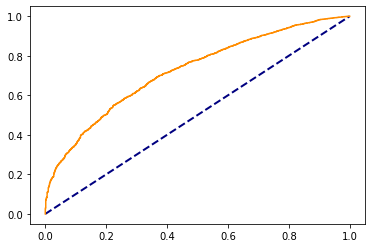

In [10]:
visualize.classification_reports(baseline_model,X,y)

### Data Cleaning

In contrast to previous experiments, I have used the standard scaler on all the data, not just based on specific base models. In addition, I have also used the SMOTE oversampling method on all training data.

In [11]:
sm = SMOTE(random_state=42)
scaler =  StandardScaler()

X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

X_sm, y_sm = sm.fit_resample(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm,
                                                  test_size=0.2,
                                                  random_state=42)

# Train an SVM Classifier
Train a base model to see the general performance of the base classifier.

In [12]:
svm_model = SVC(probability = True, verbose = True)

params_dist = {
    'C': [0.1,0.5,1],
    'kernel': ['linear','poly','rbf','sigmoid'],
    'shrinking': [True,False],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}

cv = RandomizedSearchCV(estimator = svm_model,
                        param_distributions=params_dist,
        random_state=1,
    n_iter=12,
    cv=7,
    n_jobs=-1,
    verbose=10
)
                   
cv.fit(X_train,y_train)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[LibSVM]

RandomizedSearchCV(cv=7, estimator=SVC(probability=True, verbose=True),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 1],
                                        'class_weight': ['balanced'],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'shrinking': [True, False]},
                   random_state=1, verbose=10)

In [13]:
cv.best_params_

{'shrinking': True,
 'kernel': 'rbf',
 'gamma': 'scale',
 'class_weight': 'balanced',
 'C': 1}

### Inspect Results

 class 1 :  1353
 class 0 :  1315
Confusion Matrix: 
 [[1039  276]
 [ 491  862]]
Accuracy:  0.7125187406296851
AUC:  0.7947456574462046
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      1315
           1       0.76      0.64      0.69      1353

    accuracy                           0.71      2668
   macro avg       0.72      0.71      0.71      2668
weighted avg       0.72      0.71      0.71      2668



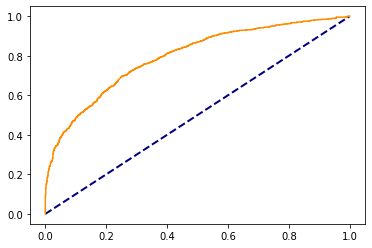

In [14]:
visualize.classification_reports(cv,X_val,y_val)

Based on the validation set, the model is clearly fitting the data on par with our baseline model. Therefore it should be included in our voting classifier to see if it improves results.

## Include in Voting Classifier

In [15]:
rf_pipe = Pipeline([
        ('classifier', RandomForestClassifier(oob_score = True))
])


lr_pipe = Pipeline([
                 ('pca', PCA()),
        ('classifier',   LogisticRegression(max_iter = 10000))
])

svm_model = SVC(probability = True, verbose = True)

voter = VotingClassifier(estimators = [('rf',rf_pipe),('lr',lr_pipe),('svm',svm_model)], voting = 'soft')

param_dist = {
    'weights': [[1,1,1],[1,1,2],[1,2,1],[2,1,1],[3,2,1],[2,3,1],[2,1,3],[1,2,3]],
    'lr__classifier__penalty': ['l2'],
    'rf__classifier__n_estimators': [1000],
    'rf__classifier__max_depth': [3,4,5],
    'rf__classifier__max_features': ['log2', None],
    'rf__classifier__class_weight': ['balanced'],
    'svm__C': [1],
    'svm__kernel': ['linear','poly','rbf','sigmoid'],
    'svm__shrinking': [True,False],
    'svm__gamma': ['scale', 'auto'],
    'svm__class_weight': ['balanced']
}

cv = RandomizedSearchCV(
    estimator=voter,
    param_distributions=param_dist,
    random_state=1,
    n_iter=20,
    cv=10,
    n_jobs=-1,
    verbose=10
)


In [ ]:
cv.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [ ]:
visualize.classification_reports(cv,X_train,y_train)

In [ ]:
visualize.classification_reports(cv,X_val,y_val)

In [ ]:
visualize.classification_reports(cv,X,y)

## Submit Predictions

In [ ]:
submit_predictions.submit_predictions(cv, X_test, test_id,"SVM_voting model", pred_path=processed_data_dir/'12964298_week3_SVM_voting.csv')

## Save Model

In [ ]:
file_name = models_dir /'brackenrig_mark_12964298_week3_SVM_voting.sav'
pkl.dump(calibrated_model, open(file_name, 'wb'))